In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from SALib.analyze import sobol
from ema_workbench.analysis import feature_scoring
from Convience_fun import create_scenario
import warnings
warnings.filterwarnings("ignore")
from ema_workbench.em_framework.salib_samplers import get_SALib_problem
from ema_workbench import (
    Model,
    Policy,
    ema_logging,
    SequentialEvaluator,
    MultiprocessingEvaluator,
    Scenario

)
from dike_model_function import DikeNetwork  # @UnresolvedImport
from problem_formulation import get_model_for_problem_formulation, sum_over, sum_over_time
from ema_workbench.analysis import prim
from ema_workbench import perform_experiments
from ema_workbench import Samplers
from ema_workbench import SequentialEvaluator
from ema_workbench.em_framework.parameters import Constant
import pickle
import itertools

In [2]:
dike_model, planning_steps = get_model_for_problem_formulation(3)

In [4]:
with open("data\ScenariosOpenExplo2.0", 'rb') as f:
    scen_prim = pickle.load(f)

In [ ]:
# uncertainties = Scenario("SCEN1",**{'discount rate 0': 0,
#     'discount rate 1': 0,
#     'discount rate 2': 0,
#     'A.0_ID flood wave shape': 0,
#     'A.1_Bmax': 200,
#     'A.1_pfail': 0.9833438536152244,
#     'A.1_Brate': 1 ,
#     'A.2_Bmax': 200,
#     'A.2_pfail': 0.9601872768253088,
#     'A.2_Brate': 1,
#     'A.3_Bmax': 200,
#     'A.3_pfail': 0.951145688071847,
#     'A.3_Brate': 1,
#     'A.4_Bmax': 200,
#     'A.4_pfail': 1,
#     'A.4_Brate': 1,
#     'A.5_Bmax': 200,
#     'A.5_pfail': 0.29973752703517675,
#     'A.5_Brate': 1})

In [6]:
with MultiprocessingEvaluator(dike_model) as evaluator:
    results = evaluator.perform_experiments(scen_prim,6700)


100%|████████████████████████████████████| 20100/20100 [46:02<00:00,  7.28it/s]


In [7]:
experiments, outcomes = results

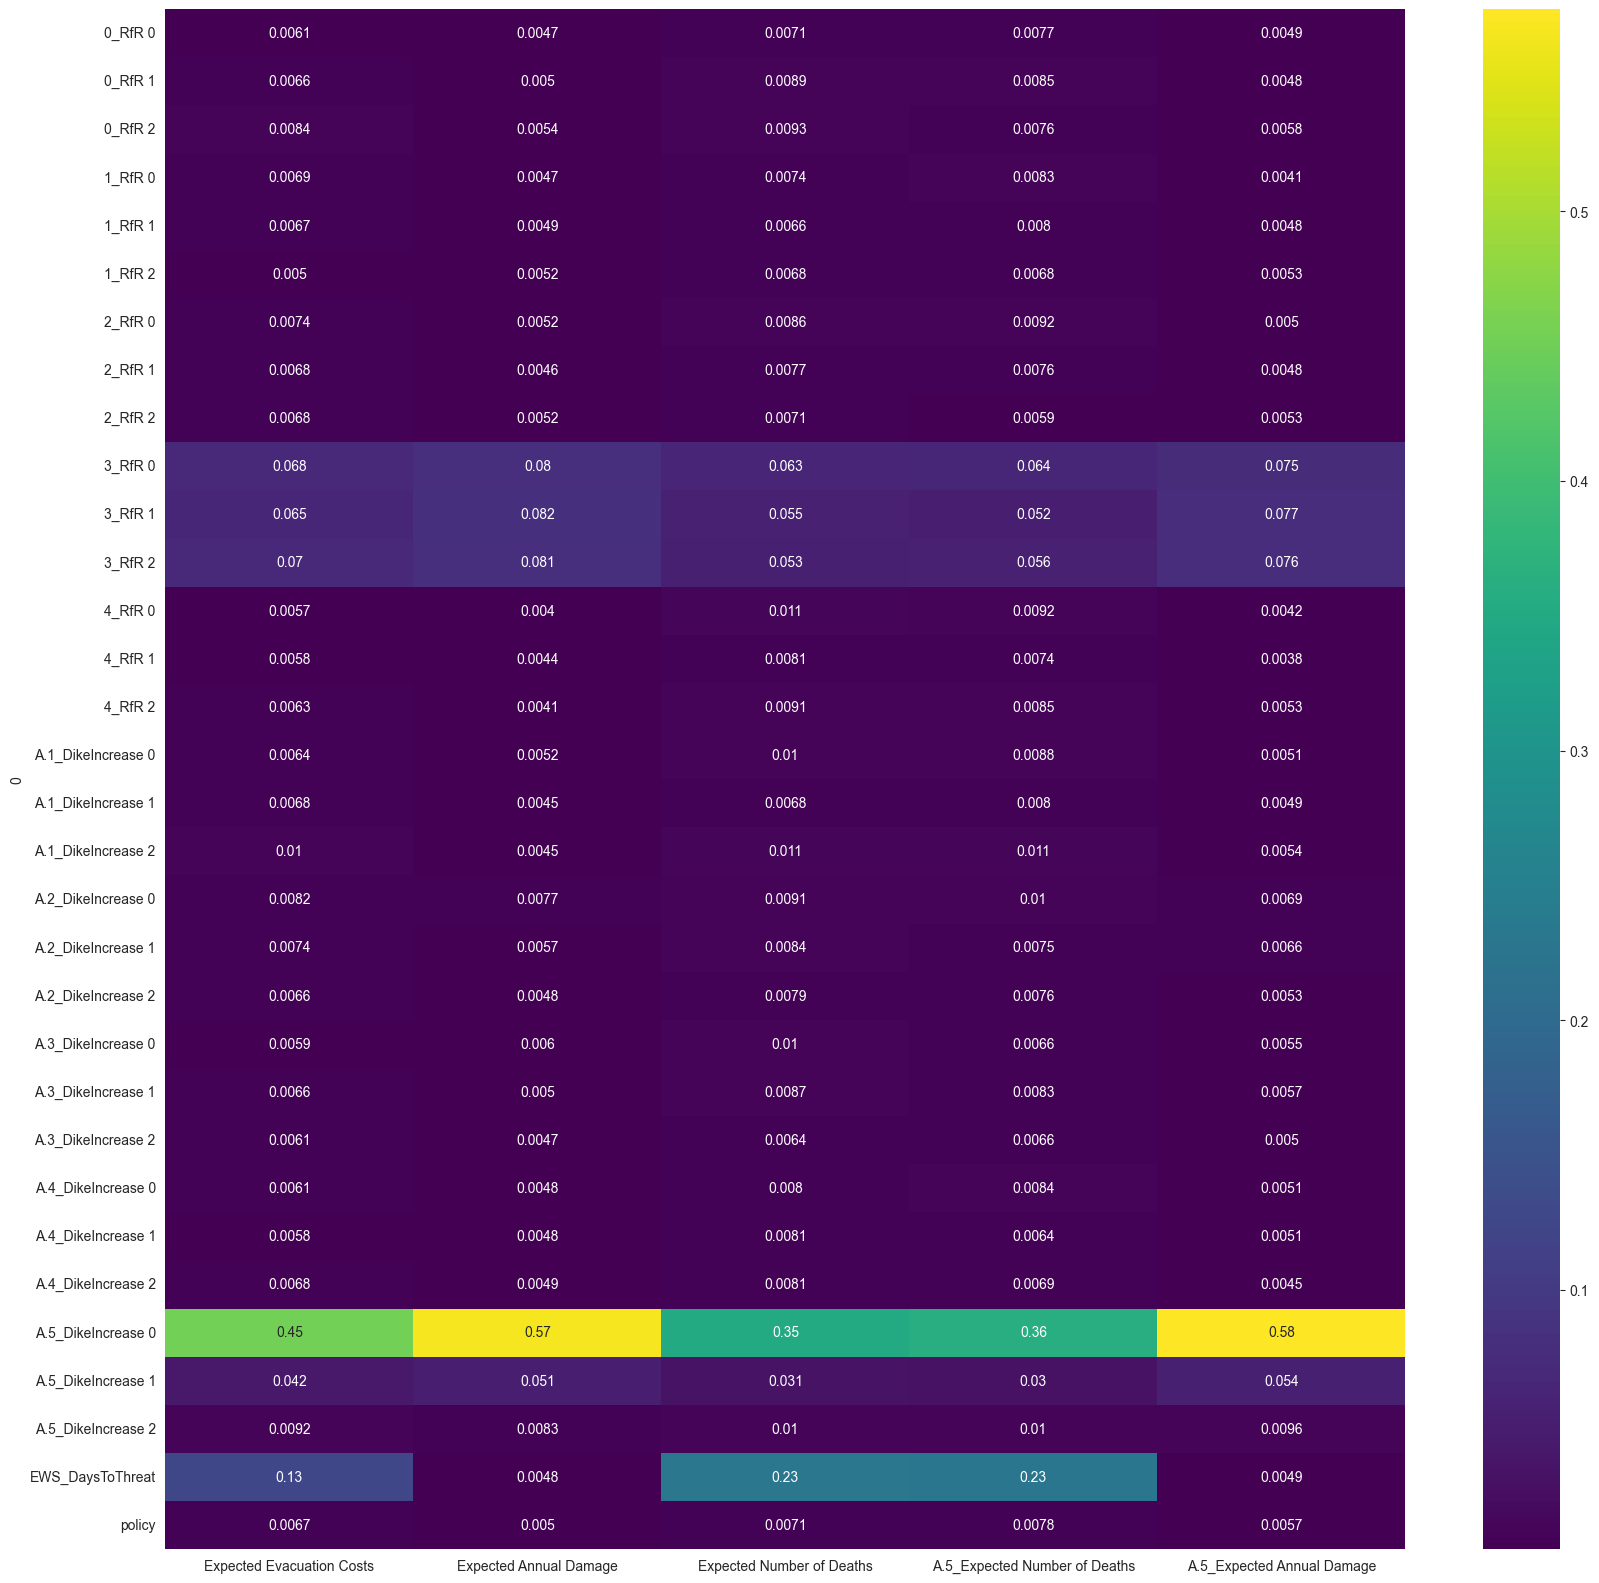

In [12]:
experiments_unc = experiments.iloc[:, 19:]
outcomes.keys()
df = pd.DataFrame(outcomes)

df["Expected Annual Damage"] = df["A.1_Expected Annual Damage"] + df["A.2_Expected Annual Damage"] + df[
    "A.3_Expected Annual Damage"] + df["A.4_Expected Annual Damage"] + df["A.5_Expected Annual Damage"]
df["Expected Number of Deaths"] = df["A.1_Expected Number of Deaths"] + df["A.2_Expected Number of Deaths"] + df[
    "A.3_Expected Number of Deaths"] + df["A.4_Expected Number of Deaths"] + df["A.5_Expected Number of Deaths"]
df_feature_importance_out = df[["Expected Evacuation Costs","Expected Annual Damage", "Expected Number of Deaths", "A.5_Expected Number of Deaths",
                                "A.5_Expected Annual Damage"]]

x = experiments_unc
y = df_feature_importance_out
fig, ax = plt.subplots(figsize=(20,20))
fs = feature_scoring.get_feature_scores_all(x, y)
sns.heatmap(fs, cmap="viridis", annot=True,ax=ax)
plt.show()

In [15]:
from ema_workbench.analysis import RuleInductionType

y = ((df_feature_importance_out["Expected Evacuation Costs"] >= list(np.sort(df_feature_importance_out["Expected Evacuation Costs"]))[int(0.80* len(df_feature_importance_out["Expected Evacuation Costs"]))]))

fs, alg = feature_scoring.get_ex_feature_scores(x, y, mode=RuleInductionType.CLASSIFICATION)

fs.sort_values(ascending=False, by=1).head(10)

,1
0,
A.5_DikeIncrease 0,0.545760
EWS_DaysToThreat,0.145829
3_RfR 1,0.035552
3_RfR 0,0.033203
3_RfR 2,0.032949
A.5_DikeIncrease 1,0.014519
A.3_DikeIncrease 0,0.009147
A.2_DikeIncrease 0,0.008193
A.3_DikeIncrease 1,0.008074


In [16]:
from ema_workbench.analysis import RuleInductionType

y = ((df_feature_importance_out["A.5_Expected Number of Deaths"] > list(np.sort(df_feature_importance_out["A.5_Expected Number of Deaths"]))[np.int64(0.80* len(df_feature_importance_out["A.5_Expected Number of Deaths"]))])
    |(df_feature_importance_out['A.5_Expected Annual Damage'] > list(np.sort(df_feature_importance_out['A.5_Expected Annual Damage']))[np.int64(0.80* len(df_feature_importance_out['A.5_Expected Annual Damage']))])
     )

fs, alg = feature_scoring.get_ex_feature_scores(x, y, mode=RuleInductionType.CLASSIFICATION)

fs.sort_values(ascending=False, by=1).head(10)

,1
0,
A.5_DikeIncrease 0,0.636598
EWS_DaysToThreat,0.049967
3_RfR 1,0.040845
3_RfR 0,0.037007
3_RfR 2,0.034729
A.5_DikeIncrease 1,0.016668
A.2_DikeIncrease 0,0.009190
A.2_DikeIncrease 1,0.008211
A.3_DikeIncrease 2,0.008008


In [17]:
from ema_workbench.analysis import RuleInductionType

y = (
    (df_feature_importance_out['Expected Number of Deaths'] > list(np.sort(df_feature_importance_out["Expected Number of Deaths"]))[np.int64(0.8* len(df_feature_importance_out['Expected Number of Deaths']))])
     |(df_feature_importance_out['Expected Annual Damage'] > list(np.sort(df_feature_importance_out["Expected Annual Damage"]))[np.int64(0.8* len(df_feature_importance_out['Expected Annual Damage']))])
     )

fs, alg = feature_scoring.get_ex_feature_scores(x, y, mode=RuleInductionType.CLASSIFICATION)

fs.sort_values(ascending=False, by=1).head(10)

,1
0,
A.5_DikeIncrease 0,0.548281
EWS_DaysToThreat,0.070988
3_RfR 1,0.041697
3_RfR 2,0.039269
3_RfR 0,0.037918
A.5_DikeIncrease 1,0.017829
A.3_DikeIncrease 0,0.015956
A.2_DikeIncrease 0,0.015164
2_RfR 0,0.009880


### SOBOL

In [19]:
dike_model_1, planning_steps = get_model_for_problem_formulation(3)

dele = []

for x in dike_model_1.levers:

    if x.name not in ["3_RfR 2","3_RfR 1","3_RfR 0","A.5_DikeIncrease 0","A.5_DikeIncrease 1","EWS_DaysToThreat"]:

        dele.append(x.name)

for i in dele:
    dike_model_1.levers.__delitem__(i)

    dike_model_1.constants.extend(Constant(i,0))

In [22]:
with MultiprocessingEvaluator(dike_model_1) as evaluator:
    results = evaluator.perform_experiments(scen_prim,2400,lever_sampling=Samplers.SOBOL)

100%|██████████████████████████████████| 50400/50400 [1:31:48<00:00,  9.15it/s]


In [39]:
experiments_1, outcomes_1 = results

In [40]:
experiments_levers = experiments_1.iloc[:, 19:-3]

In [41]:
experiments_levers

,3_RfR 0,3_RfR 1,3_RfR 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,EWS_DaysToThreat
0,0,0,1,5,9,1
1,0,0,1,5,9,1
2,0,0,1,5,9,1
3,1,0,1,5,9,1
4,1,0,1,5,9,1
...,...,...,...,...,...,...
50395,0,1,1,0,7,4
50396,0,1,1,0,7,4
50397,0,1,1,0,7,1
50398,0,1,1,0,7,1


In [42]:

df = pd.DataFrame(outcomes_1)
df["Expected Number of Deaths"] = df["A.1_Expected Number of Deaths"] + df["A.2_Expected Number of Deaths"] + df[
    "A.3_Expected Number of Deaths"] + df["A.4_Expected Number of Deaths"] + df["A.5_Expected Number of Deaths"]

df["Expected Annual Damage"] = df["A.1_Expected Annual Damage"] + df["A.2_Expected Annual Damage"] + df["A.3_Expected Annual Damage"] + df["A.4_Expected Annual Damage"] + df["A.5_Expected Annual Damage"]

df_feature_importance_out = df[["Expected Annual Damage", "Expected Number of Deaths","A.5_Expected Annual Damage", "A.5_Expected Number of Deaths", "A.5 Total Costs"]]
## Feature importance


In [43]:
outcomes_1["Expected Number of Deaths"] = df["Expected Number of Deaths"]
outcomes_1["Expected Annual Damage"] = df["Expected Annual Damage"]

In [44]:
problem

{'num_vars': 6,
 'names': ['3_RfR 0',
  '3_RfR 1',
  '3_RfR 2',
  'A.5_DikeIncrease 0',
  'A.5_DikeIncrease 1',
  'EWS_DaysToThreat'],
 'bounds': [(0, 2), (0, 2), (0, 2), (0, 11), (0, 11), (0, 5)]}

In [47]:
list(dike_model_1.levers)

[IntegerParameter('3_RfR 0', 0, 1, resolution=None, default=None, variable_name=['3_RfR 0'], pff=False),
 IntegerParameter('3_RfR 1', 0, 1, resolution=None, default=None, variable_name=['3_RfR 1'], pff=False),
 IntegerParameter('3_RfR 2', 0, 1, resolution=None, default=None, variable_name=['3_RfR 2'], pff=False),
 IntegerParameter('EWS_DaysToThreat', 0, 4, resolution=None, default=None, variable_name=['EWS_DaysToThreat'], pff=False),
 IntegerParameter('A.5_DikeIncrease 0', 0, 10, resolution=None, default=None, variable_name=['A.5_DikeIncrease 0'], pff=False),
 IntegerParameter('A.5_DikeIncrease 1', 0, 10, resolution=None, default=None, variable_name=['A.5_DikeIncrease 1'], pff=False)]

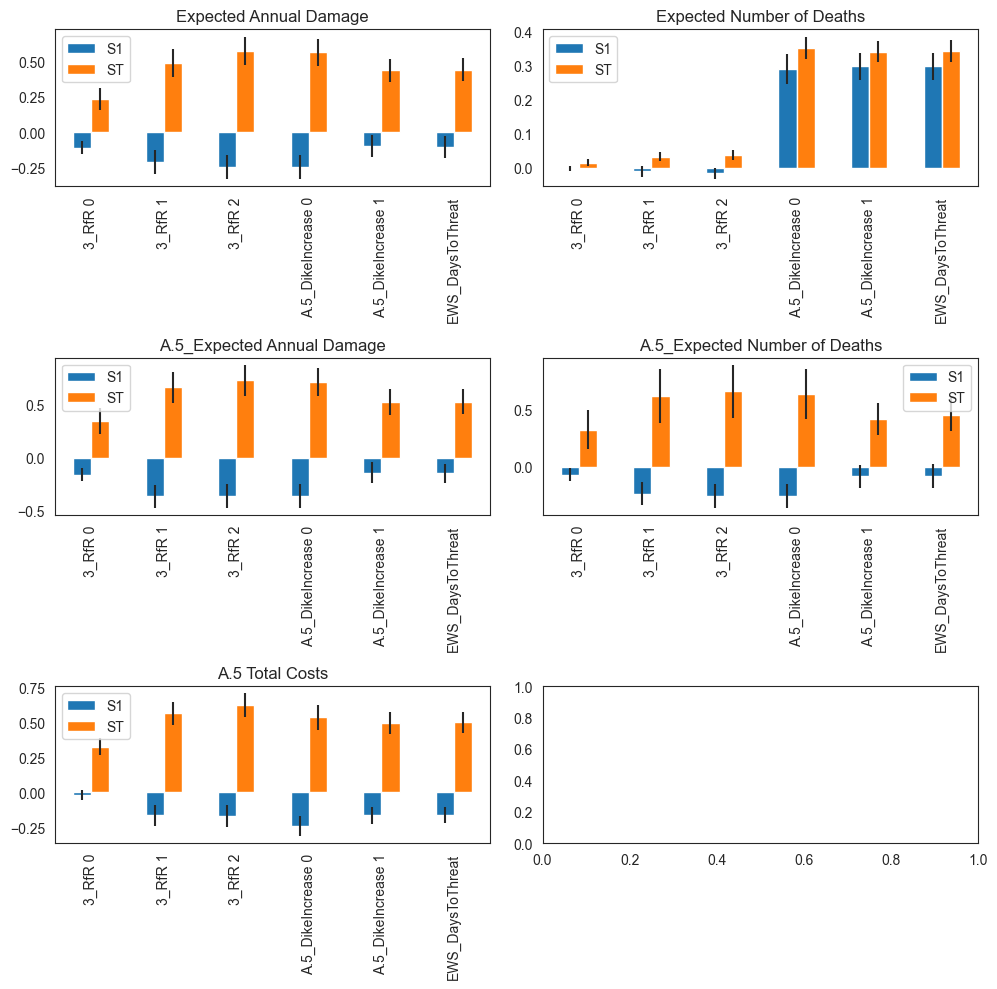

In [45]:
problem = get_SALib_problem(dike_model_1.levers)

sns.set_style('white')
fig, ax = plt.subplots(3, 2, figsize=(10, 10))
ax = ax.flatten()

for index, kpi in enumerate(df_feature_importance_out.columns):
    Si = sobol.analyze(problem, np.array(outcomes_1[kpi]), calc_second_order=True, print_to_console=False)
    Si_filter = {k: Si[k] for k in ['ST', 'ST_conf', 'S1', 'S1_conf']}
    Si_df = pd.DataFrame(Si_filter, index=problem['names'])

    indices = Si_df[['S1', 'ST']]
    err = Si_df[['S1_conf', 'ST_conf']]
    ax[index].title.set_text(kpi)
    indices.plot.bar(yerr=err.values.T, ax=ax[index])
    # fig.set_size_inches(8,6)
    # fig.subplots_adjust(bottom=0.3)
plt.tight_layout()
plt.show()